In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import os
import glob
import dask.array as da
import datetime as dt

In [2]:
# ind=(mm==(im-1)%12)|(mm==im)|(mm==(im+1)%12) # 3 month groups running mean

In [3]:
f=xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW/newHindcastMonthly/sst_HC_l0_1991_2020.nc')

In [4]:
# ensemble members 1-20 = GEM5.2-NEMO
# ensemble members 21-40 = CanESM5
ens=dict(GN=f.sst.isel(M=slice(0,20)),
         C5=f.sst.isel(M=slice(20,40)))

In [5]:
Emean={}
for imod in ('GM','C5'):
    Emean[imod]=ens[imod]
GN_Emean=GN.mean(dim='M',keepdims=True)

In [6]:
C5_Emean=C5.mean(dim='M',keepdims=True)

In [7]:
nt,nm,ny,nx=np.shape(C5)
nt,nm,ny,nx

(108, 20, 180, 360)

In [8]:
GN_clim=da.zeros((12,1,ny,nx))
C5_clim=da.zeros((12,1,ny,nx))

In [9]:
GN_clim

dask.array<zeros_like, shape=(12, 1, 180, 360), dtype=float64, chunksize=(12, 1, 180, 360), chunktype=numpy.ndarray>

In [10]:
print(dt.datetime.now())
for im in range(0,12):
    GN_clim[im,...]=GN_Emean.isel(S=slice(im,-1,12)).mean(dim='S').compute()
    C5_clim[im,...]=C5_Emean.isel(S=slice(im,-1,12)).mean(dim='S').compute()
    print(dt.datetime.now())

2024-08-13 22:55:02.783747
2024-08-13 22:55:02.790527
2024-08-13 22:55:02.795683
2024-08-13 22:55:02.800842
2024-08-13 22:55:02.805843
2024-08-13 22:55:02.810894
2024-08-13 22:55:02.815841
2024-08-13 22:55:02.820830
2024-08-13 22:55:02.825916
2024-08-13 22:55:02.830984
2024-08-13 22:55:02.836031
2024-08-13 22:55:02.841060
2024-08-13 22:55:02.845712


In [11]:
GN_clim

dask.array<setitem, shape=(12, 1, 180, 360), dtype=float64, chunksize=(12, 1, 180, 360), chunktype=numpy.ndarray>

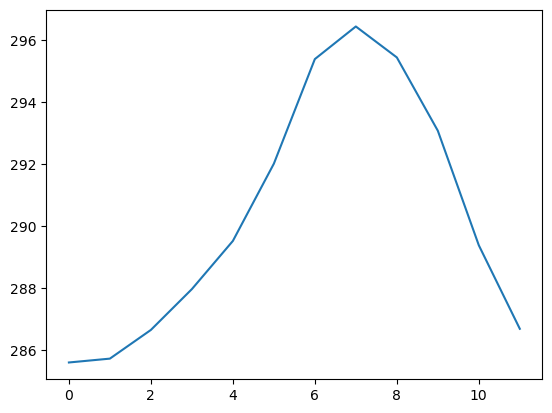

In [12]:
plt.plot(GN_clim[:,0,120,100])

In [13]:
print(dt.datetime.now())
GNanom=GN.data-da.tile(GN_clim,(int(nt/12),nm,1,1))
print(dt.datetime.now())

2024-08-13 22:55:06.850851
2024-08-13 22:55:07.670201


In [14]:
C5anom=GN-da.tile(C5_clim,(int(nt/12),nm,1,1))
print(dt.datetime.now())

2024-08-13 22:55:08.490141


In [15]:
GNanom

dask.array<subtract, shape=(108, 20, 180, 360), dtype=float64, chunksize=(12, 1, 180, 360), chunktype=numpy.ndarray>

In [16]:
GNanom.shape

(108, 20, 180, 360)

In [17]:
vec=GNanom[:,5,100,100]
vec

dask.array<getitem, shape=(108,), dtype=float64, chunksize=(12,), chunktype=numpy.ndarray>

/home/ords/crd/ccrn/reo000/miniconda3/envs/py39dc2/lib/python3.9/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


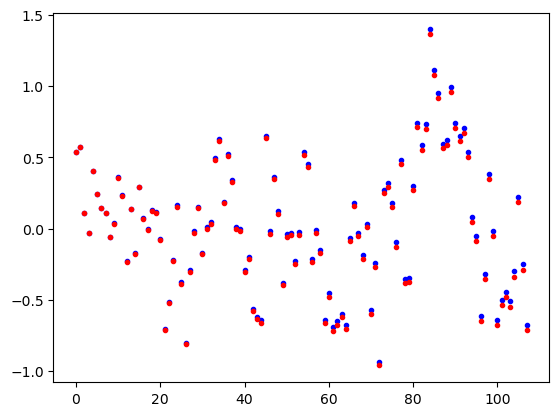

In [18]:
N=len(vec)
X=np.concatenate([np.ones((N,1)), np.expand_dims(np.arange(0,N),1)],1)
p=np.polyfit(np.arange(0,N),vec,1)
vec2=vec-p[0]*np.arange(0,N)
plt.plot(vec,'b.')
plt.plot(vec2,'r.')

In [73]:
def test(vec):
    return np.arange(0,len(vec))#np.mean(vec)*np.ones((len(vec),))

In [43]:
GNanom

dask.array<subtract, shape=(108, 20, 180, 360), dtype=float64, chunksize=(12, 1, 180, 360), chunktype=numpy.ndarray>

In [44]:
temp=test(vec)#vec=GNanom[:,5,100,100]

np.max(np.abs(np.unique(temp)-GNanom.mean(axis=0)[5,100,100])).compute()

0.0

In [74]:
#testout = xr.apply_ufunc(test, GNanom, input_core_dims=['S'], output_core_dims=['S'],dask = 'allowed', vectorize = True)
testout=da.apply_along_axis(test,0,GNanom,shape=(GNanom.shape[0],))

In [76]:
testout[2,5,100,100].compute()

2

In [66]:
(testout[1,5,100,100]-temp[0]).compute()

0.0

In [67]:
np.max(np.abs(GNanom.mean(axis=0)-testout[-1,...])).compute()

0.0

In [68]:
np.max(np.abs(GNanom.mean(axis=0)-testout[5,...])).compute()

0.0

In [84]:
def _detrend_1d(vec):
    ii=~np.isnan(vec)
    x=np.arange(0,len(vec))
    if np.sum(ii)>0:
        p=np.polyfit(x[ii].flatten(),vec[ii].flatten(),1)
        return vec-p[0]*x
    else:
        return vec # in this case should be all NaNs

In [85]:
GNanom_detr=da.apply_along_axis(_detrend_1d,0,GNanom,shape=(GNanom.shape[0],),dtype=np.float64)
print(dt.datetime.now())

2024-08-13 23:35:00.148703


In [86]:
C5anom_detr=da.apply_along_axis(_detrend_1d,0,C5anom,shape=(GNanom.shape[0],),dtype=np.float64)
print(dt.datetime.now())

2024-08-13 23:35:00.346730


In [ ]:
GN_clim={'raw':da.zeros((12,1,ny,nx)),'detr':da.zeros((12,1,ny,nx))}
C5_clim=da.zeros((12,1,ny,nx))
GN_clim_detr=da.zeros((12,1,ny,nx))
C5_clim_detr=da.zeros((12,1,ny,nx))